In [17]:
import lasagne 
import theano

import theano.tensor as T

from lasagne.layers import InputLayer, Conv2DLayer, MaxPool2DLayer, DenseLayer, DropoutLayer, batch_norm, NonlinearityLayer
from lasagne.nonlinearities import softmax, elu, rectify

In [159]:
def build_network(input_shape, input_var):
    net = InputLayer(input_shape)
    net = Conv2DLayer(net, num_filters=64, filter_size=5, nonlinearity=rectify)
    net = MaxPool2DLayer(net, pool_size=2)
    net = Conv2DLayer(net, num_filters=128, filter_size=3, nonlinearity=rectify)
    net = MaxPool2DLayer(net, pool_size=2)
    net = Conv2DLayer(net, num_filters=256, filter_size=3, nonlinearity=rectify)
    net = DenseLayer(net, num_units=1024, nonlinearity=rectify)
    net = DenseLayer(net, num_units=10, nonlinearity=softmax)
    
    return net

In [160]:
input_X = T.tensor4('input')
target = T.ivector('target')

In [161]:
nn = build_network((None, 3, 32, 32), input_X)

In [162]:
params = lasagne.layers.get_all_params(nn, trainable=True)
output = lasagne.layers.get_output(nn, input_X, deterministic=False)
obj = lasagne.objectives.categorical_crossentropy(output, target).mean()
updates = lasagne.updates.adamax(obj, params, learning_rate=1e-3)
accuracy = lasagne.objectives.categorical_accuracy(output, target).mean()

In [163]:
train = theano.function([input_X, target], [obj, accuracy], updates=updates)
evaluate = theano.function([input_X, target], accuracy)
predict = theano.function([input_X], lasagne.layers.get_output(nn, input_X, deterministic=True))

In [164]:
import time
import matplotlib.pyplot as plt

%matplotlib inline

def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    
    if inputs.shape[0] < batchsize:
        yield inputs, targets
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]
        

def learn(dataset, num_epochs=100, batchsize=500):
    '''
        num_epochs - amount of passes through the data
        dataset - [X_train, X_val, y_train, y_val]
    '''
    
    X_train, X_val, y_train, y_val = dataset
    objectives = [None] * num_epochs
    best_model = None
    best_acc = 0

    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:
        train_err = 0
        train_acc = 0
        train_batches = 0
        start_time = time.time()

        for batch in iterate_minibatches(X_train, y_train, batchsize, True):
            inputs, targets = batch
            train_err_batch, train_acc_batch = train(inputs, targets)
            train_err += train_err_batch
            train_acc += train_acc_batch
            train_batches += 1

        # And a full pass over the validation data:
        val_acc = 0
        val_batches = 0

        for batch in iterate_minibatches(X_val, y_val, batchsize):
            inputs, targets = batch
            val_acc += evaluate(inputs, targets)
            val_batches += 1

        if epoch % 10 == 0:
            # Then we print the results for this epoch:
            print('Epoch {} of {} took {:.3f}s'.format(epoch, num_epochs, time.time() - start_time))
            print('  training loss (in-iteration):\t\t{:.6f}'.format(train_err / train_batches))
            print('  train accuracy:\t\t{:.2f} %'.format(train_acc / train_batches * 100))
            print('  validation accuracy:\t\t{:.2f} %'.format(val_acc / val_batches * 100))
        
        objectives[epoch] = train_err / (train_batches + 1)
        
    plt.title('Learning Curve')
    plt.plot(objectives)
    plt.xlabel('Num Epoch')
    plt.ylabel('Cross Entropy')
    plt.show()

In [165]:
import pandas as pd

df_train_target = pd.read_csv('Ytr.csv', sep = ',', header = None, skiprows=1)
df_train = pd.read_csv('Xtr.csv', sep = ',', header = None)
df_test = pd.read_csv('Xte.csv', sep = ',', header = None)

In [169]:
df_test

,0,1,2,3,4,5,6,7,8,9,...,3063,3064,3065,3066,3067,3068,3069,3070,3071,3072
0,0.021317,-0.029188,-0.021746,-0.029482,0.011179,0.032251,0.013757,0.015677,-0.049118,-0.051430,...,0.013725,0.123213,-0.006638,-0.043762,-0.011082,-0.003506,-0.007296,-0.020889,-0.024223,NaN
1,0.038809,0.017464,0.033951,0.062252,0.051475,0.071586,0.076982,0.078035,0.058132,0.008797,...,-0.010371,-0.016821,0.008783,-0.007583,-0.024359,-0.002662,-0.003553,-0.000605,0.000030,NaN
2,-0.013505,-0.040433,-0.023872,-0.017034,0.005898,0.015000,-0.005875,-0.028056,-0.005516,-0.025364,...,0.000917,0.008904,0.010832,-0.000609,0.001183,0.000750,-0.006280,0.018178,0.009699,NaN
3,0.079833,0.087111,0.095980,0.085299,0.090196,0.092923,0.085450,0.093836,0.089580,0.089868,...,0.003782,0.015810,0.006891,-0.001391,0.005947,0.015124,0.012474,-0.013197,-0.037887,NaN
4,0.003421,-0.012074,0.003435,0.002495,0.017810,0.009306,-0.011229,-0.040445,-0.028034,0.059742,...,0.004841,0.013999,0.020970,0.043955,0.026964,0.030705,-0.002225,0.009616,0.006040,NaN
5,0.002235,-0.001436,-0.001510,0.005397,-0.001300,-0.000326,-0.000283,-0.000483,-0.000515,-0.000552,...,0.000184,0.002762,-0.004692,-0.004202,-0.003634,-0.000311,-0.004221,-0.003897,0.002847,NaN
6,0.013060,-0.009028,-0.021637,-0.022661,-0.025891,-0.022931,-0.024733,-0.033114,-0.031494,-0.038910,...,0.006623,-0.002786,-0.002075,-0.004846,-0.002113,-0.006232,-0.014587,-0.076449,-0.031167,NaN
7,0.010942,0.006328,0.002636,0.006784,0.008367,0.001298,0.006004,0.003266,-0.004742,-0.006500,...,-0.005236,-0.001792,-0.003260,-0.003570,-0.001974,0.008249,-0.001909,-0.002572,-0.002357,NaN
8,0.010323,-0.000446,-0.028734,0.002662,0.003080,-0.016970,-0.023255,-0.032693,-0.025744,0.009961,...,-0.003864,-0.002841,-0.015710,-0.013947,0.006856,0.030468,0.056211,0.056140,0.060534,NaN
9,0.033041,0.022215,0.017222,0.023705,0.027109,0.033807,0.018699,0.017393,0.029579,0.020493,...,0.032927,0.020618,-0.002640,0.008354,-0.005770,0.008310,-0.005025,-0.000503,-0.004402,NaN


In [171]:
import numpy as np

df_train_cleared = df_train.drop(3072, 1)
df_test_cleared = df_test.drop(3072, 1)
y_train = np.array(df_train_target[1])
X_train = np.array(df_train_cleared).reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)# + np.array([0.25, 0.2, 0.2])
X_test = np.array(df_test_cleared).reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

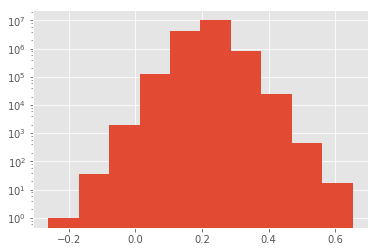

In [167]:
plt.hist((X_train + np.array([0.25, 0.2, 0.2])).ravel())
plt.yscale('log')

In [168]:
from sklearn.model_selection import train_test_split

dataset = train_test_split(X_train.reshape(-1, 3, 32, 32).astype(np.float32), y_train.astype(np.int32))
learn(dataset, num_epochs=1000, batchsize=1000)

Epoch 0 of 1000 took 0.308s
  training loss (in-iteration):		2.303082
  train accuracy:		9.40 %
  validation accuracy:		10.60 %
Epoch 10 of 1000 took 0.269s
  training loss (in-iteration):		2.148508
  train accuracy:		20.40 %
  validation accuracy:		19.30 %
Epoch 20 of 1000 took 0.270s
  training loss (in-iteration):		2.003328
  train accuracy:		26.50 %
  validation accuracy:		24.70 %
Epoch 30 of 1000 took 0.271s
  training loss (in-iteration):		1.914612
  train accuracy:		29.40 %
  validation accuracy:		25.50 %
Epoch 40 of 1000 took 0.272s
  training loss (in-iteration):		1.854587
  train accuracy:		32.10 %
  validation accuracy:		27.50 %
Epoch 50 of 1000 took 0.277s
  training loss (in-iteration):		1.806063
  train accuracy:		33.40 %
  validation accuracy:		28.50 %
Epoch 60 of 1000 took 0.276s
  training loss (in-iteration):		1.762832
  train accuracy:		35.27 %
  validation accuracy:		29.00 %
Epoch 70 of 1000 took 0.277s
  training loss (in-iteration):		1.727092
  train accuracy:		37

KeyboardInterrupt: 

In [ ]:
evaluate(dataset[1], dataset[-1])

In [26]:
np.savez('trained_weights', *lasagne.layers.get_all_param_values(nn))

In [64]:
with np.load('trained_weights.npz') as f:
            param_values = [f['arr_%d' % i] for i in range(len(f.files))]
            lasagne.layers.set_all_param_values(nn, param_values)

In [67]:
dataset = train_test_split(X_train.reshape(-1, 3, 32, 32).astype(np.float32), y_train.astype(np.int32))

In [174]:
X_test.shape

(2000, 32, 32, 3)

In [182]:
pred = np.argmax(predict(X_test.reshape(-1, 3, 32, 32).astype(np.float32)), axis=1)

In [184]:
with open('answers.txt', 'wb') as f:
    for i, a in enumerate(pred):
        f.write('{},{}\n'.format(i+1, a))

# VGG16

In [59]:
# VGG-16, 16-layer model from the paper:
# "Very Deep Convolutional Networks for Large-Scale Image Recognition"
# Original source: https://gist.github.com/ksimonyan/211839e770f7b538e2d8
# License: see http://www.robots.ox.ac.uk/~vgg/research/very_deep/

# Download pretrained weights from:
# https://s3.amazonaws.com/lasagne/recipes/pretrained/imagenet/vgg16.pkl


def build_model():
    net = {}
    net['input'] = InputLayer((None, 3, 32, 32))
    net['conv1_1'] = Conv2DLayer(
        net['input'], 64, 3, pad=1, flip_filters=False)
    net['conv1_2'] = Conv2DLayer(
        net['conv1_1'], 64, 3, pad=1, flip_filters=False)
    net['pool1'] = MaxPool2DLayer(net['conv1_2'], 2)
    net['conv2_1'] = Conv2DLayer(
        net['pool1'], 128, 3, pad=1, flip_filters=False)
    net['conv2_2'] = Conv2DLayer(
        net['conv2_1'], 128, 3, pad=1, flip_filters=False)
    net['pool2'] = MaxPool2DLayer(net['conv2_2'], 2)
    net['conv3_1'] = Conv2DLayer(
        net['pool2'], 256, 3, pad=1, flip_filters=False)
    net['conv3_2'] = Conv2DLayer(
        net['conv3_1'], 256, 3, pad=1, flip_filters=False)
    net['conv3_3'] = Conv2DLayer(
        net['conv3_2'], 256, 3, pad=1, flip_filters=False)
    net['pool3'] = MaxPool2DLayer(net['conv3_3'], 2)
    net['conv4_1'] = Conv2DLayer(
        net['pool3'], 512, 3, pad=1, flip_filters=False)
    net['conv4_2'] = Conv2DLayer(
        net['conv4_1'], 512, 3, pad=1, flip_filters=False)
    net['conv4_3'] = Conv2DLayer(
        net['conv4_2'], 512, 3, pad=1, flip_filters=False)
    net['pool4'] = MaxPool2DLayer(net['conv4_3'], 2)
    net['conv5_1'] = Conv2DLayer(
        net['pool4'], 512, 3, pad=1, flip_filters=False)
    net['conv5_2'] = Conv2DLayer(
        net['conv5_1'], 512, 3, pad=1, flip_filters=False)
    net['conv5_3'] = Conv2DLayer(
        net['conv5_2'], 512, 3, pad=1, flip_filters=False)
    net['pool5'] = MaxPool2DLayer(net['conv5_3'], 2)
    net['fc6'] = DenseLayer(net['pool5'], num_units=4096)
    net['fc6_dropout'] = DropoutLayer(net['fc6'], p=0.5)
    net['fc7'] = DenseLayer(net['fc6_dropout'], num_units=4096)
    net['fc7_dropout'] = DropoutLayer(net['fc7'], p=0.5)
    net['fc8'] = DenseLayer(
        net['fc7_dropout'], num_units=10, nonlinearity=None)
    net['prob'] = NonlinearityLayer(net['fc8'], softmax)

    return net

In [60]:
vgg16 = build_model()

In [61]:
# ! wget https://s3.amazonaws.com/lasagne/recipes/pretrained/imagenet/vgg16.pkl

In [62]:
import pickle
        
with open('vgg16.pkl') as f:
    params = pickle.load(f)

lasagne.layers.set_all_param_values(lasagne.layers.get_all_layers(vgg16['prob'])[:-6], params['param values'][:-6])

In [69]:
params = lasagne.layers.get_all_params(vgg16['prob'], trainable=True)[-6:]
output = lasagne.layers.get_output(vgg16['prob'], input_X, deterministic=False)
obj = lasagne.objectives.categorical_crossentropy(output, target).mean()
updates = lasagne.updates.adagrad(obj, params, learning_rate=1e-3)
accuracy = lasagne.objectives.categorical_accuracy(output, target).mean()

In [70]:
train = theano.function([input_X, target], [obj, accuracy], updates=updates)
evaluate = theano.function([input_X, target], accuracy)
predict = theano.function([input_X], lasagne.layers.get_output(nn, input_X, deterministic=True))

Epoch 0 of 1000 took 0.694s
  training loss (in-iteration):		2.179639
  train accuracy:		19.80 %
  validation accuracy:		20.30 %
Epoch 10 of 1000 took 0.663s
  training loss (in-iteration):		1.963671
  train accuracy:		27.40 %
  validation accuracy:		26.20 %
Epoch 20 of 1000 took 0.677s
  training loss (in-iteration):		1.960422
  train accuracy:		27.43 %
  validation accuracy:		29.00 %
Epoch 30 of 1000 took 0.679s
  training loss (in-iteration):		1.943287
  train accuracy:		27.73 %
  validation accuracy:		26.50 %
Epoch 40 of 1000 took 0.682s
  training loss (in-iteration):		1.938585
  train accuracy:		28.23 %
  validation accuracy:		26.40 %
Epoch 50 of 1000 took 0.687s
  training loss (in-iteration):		1.945515
  train accuracy:		28.20 %
  validation accuracy:		27.60 %
Epoch 60 of 1000 took 0.687s
  training loss (in-iteration):		1.939003
  train accuracy:		27.97 %
  validation accuracy:		27.10 %
Epoch 70 of 1000 took 0.686s
  training loss (in-iteration):		1.942096
  train accuracy:		2

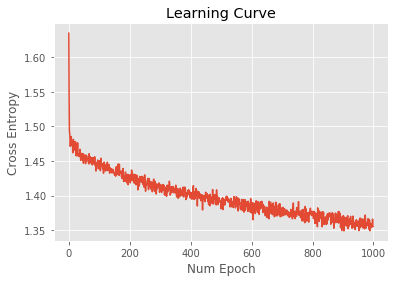

In [71]:
from sklearn.model_selection import train_test_split

dataset = train_test_split(X_train.reshape(-1, 3, 32, 32).astype(np.float32), y_train.astype(np.int32))
learn(dataset, num_epochs=1000, batchsize=1000)

In [72]:
learn(dataset, num_epochs=1000, batchsize=1000)

Epoch 0 of 1000 took 0.688s
  training loss (in-iteration):		1.816010
  train accuracy:		34.27 %
  validation accuracy:		29.80 %
Epoch 10 of 1000 took 0.667s
  training loss (in-iteration):		1.805129
  train accuracy:		34.57 %
  validation accuracy:		30.50 %
Epoch 20 of 1000 took 0.668s
  training loss (in-iteration):		1.804068
  train accuracy:		34.33 %
  validation accuracy:		31.00 %
Epoch 30 of 1000 took 0.671s
  training loss (in-iteration):		1.806924
  train accuracy:		33.80 %
  validation accuracy:		30.10 %
Epoch 40 of 1000 took 0.630s
  training loss (in-iteration):		1.810378
  train accuracy:		34.93 %
  validation accuracy:		28.60 %
Epoch 50 of 1000 took 0.608s
  training loss (in-iteration):		1.810237
  train accuracy:		34.70 %
  validation accuracy:		29.10 %
Epoch 60 of 1000 took 0.610s
  training loss (in-iteration):		1.789263
  train accuracy:		34.70 %
  validation accuracy:		30.50 %
Epoch 70 of 1000 took 0.614s
  training loss (in-iteration):		1.794184
  train accuracy:		3

KeyboardInterrupt: 

In [ ]:
learn(dataset, num_epochs=1000, batchsize=1000)

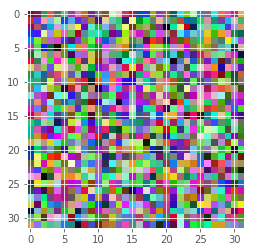

In [133]:
im = X_train.reshape(-1, 32, 32, 3)[np.random.choice(X_train.shape[0])]
plt.imshow(im * 255 + 1 *  np.array([36, 39, 40]))

In [132]:
(im * 255)[:, :, 0].astype(np.int).ravel().min()

-36

In [149]:
im.transpose(1, 2, 0).shape

(32, 3, 32)

In [147]:
plt.imshow(im.transpose(1, 2, 0) + np.array([0.25, 0.2, 0.2]))

ValueError: operands could not be broadcast together with shapes (32,3,32) (3,) 

In [136]:
(im * 255 + np.array([103.939, 116.779, 123.68])) / 

array([[[ 118.49177095,  127.0937194 ,  133.98695975],
        [ 116.6498371 ,  136.0862944 ,  131.1889289 ],
        [  96.2504797 ,  125.57739505,  131.21186105],
        ..., 
        [ 103.03549802,  125.24395705,  129.65861015],
        [ 106.68621445,  118.17013643,  123.27558479],
        [ 104.00431886,  116.61156119,  123.19729061]],

       [[ 101.87356375,  116.11873538,  124.00105801],
        [ 103.40014037,  114.1915354 ,  121.76781085],
        [ 103.06466008,  111.5255818 ,  113.4631751 ],
        ..., 
        [ 102.19314479,  115.631717  ,  112.69138445],
        [  99.87034495,  127.72411255,  128.55336365],
        [ 105.34682236,  116.64011394,  123.24799022]],

       [[ 101.61038003,  115.97705738,  126.19946171],
        [ 105.78716197,  115.26210011,  122.19450056],
        [ 101.2847968 ,  105.2105323 ,  119.52563945],
        ..., 
        [ 102.38828507,  115.16269576,  121.63420156],
        [  98.67933175,  106.4779486 ,  124.78811423],
        [ 117.97615

In [ ]:
def build_generator(imshape):
    net = InputLayer(imshape)
    net = 

In [153]:
print 1

1


In [157]:
with open('ds.pkl', 'wb') as f:
    pickle.dump(X_train, f)

In [185]:
with open('ds_labels.pkl', 'wb') as f:
    pickle.dump(y_train, f)